In [1]:
import torch

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Networks

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ActorNetwork(nn.Module):
    def __init__(self, input_dims, action_size, name, chkpt_dir='checkpoint'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.action_size = action_size
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*input_dims, 400)
        self.bn1 = nn.LayerNorm(400)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        self.fc2 = nn.Linear(400, 300)
        self.bn2 = nn.LayerNorm(300)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        self.fc3 = nn.Linear(300, self.action_size)
        f3 = 0.003
        self.fc3.weight.data.uniform_(-f3, f3)
        self.fc3.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = torch.tanh(self.fc3(x))
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        torch.save(self.state_dict(), checkpoint_file)

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, action_size, name, chkpt_dir='checkpoint'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.action_size = action_size
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*input_dims, 400)
        self.bn1 = nn.LayerNorm(400)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        self.fc2 = nn.Linear(400, 300)
        self.bn2 = nn.LayerNorm(300)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        self.action_value = nn.Linear(self.action_size, 300)
        f3 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f3, f3)
        self.action_value.bias.data.uniform_(-f3, f3)

        self.q = nn.Linear(300, 1)
        f4 = 0.003
        self.q.weight.data.uniform_(-f4, f4)
        self.q.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=0.001,
                                    weight_decay=0.01)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)

    def forward(self, state, action):
        state_value = F.relu(self.bn1(self.fc1(state)))
        state_value = self.bn2(self.fc2(state_value))

        action_value = self.action_value(action)
        state_action_value = F.relu(torch.add(state_value, action_value))

        state_action_value = self.q(state_action_value)
        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(torch.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        torch.save(self.state_dict(), checkpoint_file)

## Experience Replay

In [4]:
import numpy as np

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, new_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = new_state
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_state = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_state, dones

## DDPG Agent

In [5]:
import torch as T
import torch.nn.functional as F
from OUActionNoise import OUActionNoise

class Agent():
    def __init__(self, input_dims, action_size, tau=0.001, gamma=0.99,
                 max_size=1000000, batch_size=64, chkpt_dir='agent'):
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        self.memory = ReplayBuffer(max_size, input_dims, action_size)

        self.noise = OUActionNoise(mu=np.zeros(action_size))

        self.actor = ActorNetwork(input_dims, action_size, name='actor')
        self.critic = CriticNetwork(input_dims, action_size, name='critic')

        self.actor_target = ActorNetwork(input_dims, action_size, name='actor_target')
        self.critic_target = CriticNetwork(input_dims, action_size, name='critic_target')

        self.update_network_parameters(tau=1)

    def choose_action(self, state):
        self.actor.eval()
        state = T.from_numpy(state).float().to(self.actor.device)
        action = self.actor.forward(state[None, :]).to(self.actor.device)
        action = action + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)
        self.actor.train()
        return action.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.actor_target.save_checkpoint()
        self.critic.save_checkpoint()
        self.critic_target.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.actor_target.load_checkpoint()
        self.critic.load_checkpoint()
        self.critic_target.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, next_states, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        next_states = T.tensor(next_states, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.actor_target.forward(next_states)
        critic_value_ = self.critic_target.forward(next_states, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.actor_target.named_parameters()
        target_critic_params = self.critic_target.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.critic_target.load_state_dict(critic_state_dict)
        self.actor_target.load_state_dict(actor_state_dict)

## Lunar Lander Continous

In [6]:
!pip3 install gym --upgrade
!pip3 install pyglet
!pip3 install Box2D
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [7]:
!mkdir -p checkpoint

In [8]:
import gym

env = gym.make('LunarLanderContinuous-v2')
input_dim = env.observation_space.shape
action_size = env.action_space.shape[0]

In [9]:
n_episodes = 500
crs = []

agent = Agent(input_dim, action_size)

for i_episode in range(1, n_episodes+1):
    S = env.reset()
    done = False
    cr = 0
    agent.noise.reset()
    while not done:
        A = agent.choose_action(S)
        Sp, R, done, info = env.step(A)

        agent.remember(S, A, R, Sp, done)
        agent.learn()

        cr += R
        S = Sp
    
    crs.append(cr)
    avg_reward = np.mean(crs[-100:])

    print('episode ', i_episode, 'reward %.1f' % cr, 'average reward %.1f' % avg_reward)

    if i_episode % 100 == 0:
        agent.save_models()

episode  1 reward -218.7 average reward -218.7
episode  2 reward -279.3 average reward -249.0
episode  3 reward -433.0 average reward -310.3
episode  4 reward -787.8 average reward -429.7
episode  5 reward -468.3 average reward -437.4
episode  6 reward -506.1 average reward -448.9
episode  7 reward -763.5 average reward -493.8
episode  8 reward -176.2 average reward -454.1
episode  9 reward -232.2 average reward -429.5
episode  10 reward -183.1 average reward -404.8
episode  11 reward -244.4 average reward -390.2
episode  12 reward -284.8 average reward -381.4
episode  13 reward -256.5 average reward -371.8
episode  14 reward -375.2 average reward -372.1
episode  15 reward -273.7 average reward -365.5
episode  16 reward -119.3 average reward -350.1
episode  17 reward -171.0 average reward -339.6
episode  18 reward -111.9 average reward -326.9
episode  19 reward -97.8 average reward -314.9
episode  20 reward -179.0 average reward -308.1
episode  21 reward -176.5 average reward -301.8
ep

In [10]:
np.save('crs_lunar_lander.npy', crs)

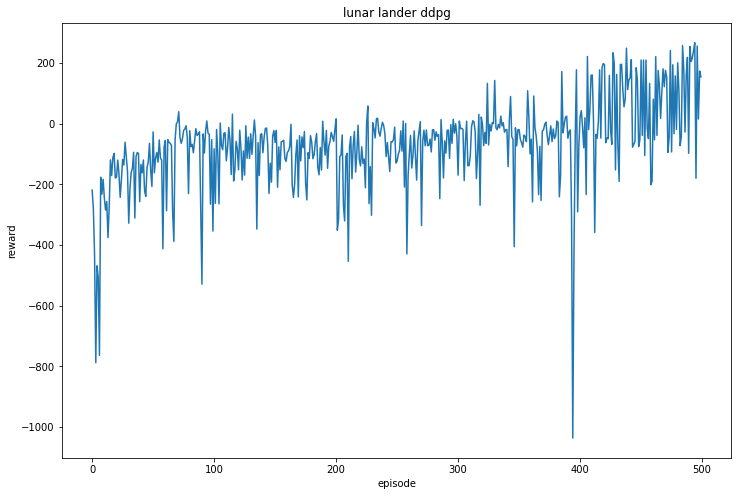

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.title('lunar lander ddpg')
plt.plot(crs)
plt.xlabel('episode')
plt.ylabel('reward')

plt.show()